In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install albumentations==0.4.3

     |████████████████████████████████| 3.2MB 4.8MB/s 
     |████████████████████████████████| 634kB 41.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.3-cp36-none-any.whl size=60764 sha256=5c2d8575512e5060dc554426a6e911e65f537d25cf737556e5109e9cb2ef2945
  Stored in directory: /root/.cache/pip/wheels/20/16/8e/d3bec34bf30adff30929226f0b83cc8c005b5af131f51db9d0
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=1abe0bc9ac50e84ce5a25dfdaca1dfd5922368f1e2fc600fa3ff9d3c47b4331d
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [0]:
from __future__ import print_function, division, absolute_import
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn.functional as F
import os
import cv2

# Any results you write to the current directory are saved as output.
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm
import math
import torch.utils.model_zoo as model_zoo

from PIL import Image, ImageOps, ImageEnhance
from albumentations.core.transforms_interface import ImageOnlyTransform

from albumentations import (
    PadIfNeeded,
    GaussianBlur,
    Flip,
    HorizontalFlip,
    Transpose,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    Rotate,
    RandomBrightnessContrast,    
    RandomGamma,
    ShiftScaleRotate ,
    GaussNoise,
    Blur,
    MotionBlur,Cutout
)
my_size = 128

In [0]:
def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

def normalize(image):
    """Normalize input image channel-wise to zero mean and unit variance."""
    return image - 127

def apply_op(image, op, severity):
    #   image = np.clip(image, 0, 255)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img)

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
    """
    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype(np.float32)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * image_aug
#         mix += ws[i] * normalize(image_aug)

    mixed = (1 - m) * image + m * mix
#     mixed = (1 - m) * normalize(image) + m * mix
    return mixed


class RandomAugMix(ImageOnlyTransform):

    def __init__(self, severity=3, width=3, depth=-1, alpha=1., always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.severity = severity
        self.width = width
        self.depth = depth
        self.alpha = alpha

    def apply(self, image, **params):
        image = augment_and_mix(
            image,
            self.severity,
            self.width,
            self.depth,
            self.alpha
        )
        return np.resize(image,(128,128))

In [0]:
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as F
class GridMask(DualTransform):

    """Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return np.resize(image,(128,128))

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')


In [0]:
train_aug = Compose([ 
    ShiftScaleRotate(rotate_limit=15, scale_limit=.1),Cutout(num_holes=1, max_h_size=48, max_w_size=64, fill_value=0, always_apply=False, p=0.7),
    OneOf([
        GridDistortion(distort_limit =0.05 ,border_mode=cv2.BORDER_CONSTANT,value =1, p=0.1),
        OpticalDistortion(p=0.1, distort_limit= 0.05, shift_limit=0.2,border_mode=cv2.BORDER_CONSTANT,value =1)                  
        ], p=0.3),
    OneOf([
        Blur(),
        GaussianBlur(blur_limit=1)
        ], p=0.3),    
    RandomGamma(p=0.3),
    
    #GridMask(num_grid=3, mode=2, p=1),    #RandomAugMix(severity=3, width=7, alpha=5, p=1.),  
    
    ])

In [0]:
class ToTensor:
    def __call__(self, data):
        if isinstance(data, tuple):
            return tuple([self._to_tensor(image) for image in data])
        else:
            return self._to_tensor(data)

    def _to_tensor(self, data):
        if len(data.shape) == 3:
            return torch.from_numpy(data.transpose(2, 0, 1).astype(np.float32))
        else:
            return torch.from_numpy(data[None, :, :].astype(np.float32))


class Normalize:
    def __init__(self, mean, std):
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, image):
        image = np.asarray(image).astype(np.float32) / 255.
        image = (image - self.mean) / self.std
        return image

In [0]:
class Selayer(nn.Module):

    def __init__(self, inplanes):
        super(Selayer, self).__init__()
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.conv1 = nn.Conv2d(inplanes, int(inplanes / 16), kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(int(inplanes / 16), inplanes, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        out = self.global_avgpool(x)

        out = self.conv1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.sigmoid(out)

        return x * out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, cardinality, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)

        self.conv2 = nn.Conv2d(planes * 2, planes * 2, kernel_size=3, stride=stride,
                               padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 2)

        self.conv3 = nn.Conv2d(planes * 2, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)

        self.selayer = Selayer(planes * 4)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.selayer(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class SeResNeXt(nn.Module):

    def __init__(self, block, layers, cardinality=32, num_classes=1000):
        super(SeResNeXt, self).__init__()
        self.cardinality = cardinality
        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, self.cardinality, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, self.cardinality))
                             
        # vowel_diacritic
        self.fc1 = nn.Linear(2048,11)
        # grapheme_root
        self.fc2 = nn.Linear(2048,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(2048,7)
        return nn.Sequential(*layers)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        
        return x1,x2,x3


def se_resnext50(**kwargs):
    """Constructs a SeResNeXt-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SeResNeXt(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def se_resnext101(**kwargs):
    """Constructs a SeResNeXt-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SeResNeXt(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model


def se_resnext152(**kwargs):
    """Constructs a SeResNeXt-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SeResNeXt(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model

In [0]:
train = pd.read_csv('/content/drive/My Drive/bengaliaicv19feather/train.csv')
data0 = pd.read_feather('/content/drive/My Drive/black_128/train_data_0_ors.feather')
data1 = pd.read_feather('/content/drive/My Drive/black_128/train_data_1_ors.feather')
data2 = pd.read_feather('/content/drive/My Drive/black_128/train_data_2_ors.feather')  
data3 = pd.read_feather('/content/drive/My Drive/black_128/train_data_3_ors.feather')

'''data0 = pd.read_feather('/content/drive/My Drive/black64/train_data_0_64.feather')
data1 = pd.read_feather('/content/drive/My Drive/black64/train_data_1_64.feather')
data2 = pd.read_feather('/content/drive/My Drive/black64/train_data_2_64.feather')  
data3 = pd.read_feather('/content/drive/My Drive/black64/train_data_3_64.feather')'''

"data0 = pd.read_feather('/content/drive/My Drive/black64/train_data_0_64.feather')\ndata1 = pd.read_feather('/content/drive/My Drive/black64/train_data_1_64.feather')\ndata2 = pd.read_feather('/content/drive/My Drive/black64/train_data_2_64.feather')  \ndata3 = pd.read_feather('/content/drive/My Drive/black64/train_data_3_64.feather')"

In [0]:
data_full = pd.concat([data0,data1,data2,data3],ignore_index=True)
del data0,data1,data2,data3

In [0]:
class GraphemeDataset(Dataset):
    def __init__(self,df,label,_type='train',transform =True,aug = train_aug):
        self.df = df
        self.label = label
        self.aug = aug
        self.transform = transform
        self.data = df.iloc[:, 1:].values
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        label1 = self.label.vowel_diacritic.values[idx]
        label2 = self.label.grapheme_root.values[idx]
        label3 = self.label.consonant_diacritic.values[idx]
        image = self.data[idx, :].reshape(my_size,my_size).astype(np.float)
        if self.transform: 
            augment = self.aug(image = image)
            image = augment['image']
        return image,label1,label2,label3

In [0]:
from sklearn.model_selection import train_test_split
train_df , valid_df = train_test_split(train,test_size=0.20, random_state=123,shuffle=True) ## Split Labels
data_train_df, data_valid_df = train_test_split(data_full,test_size=0.20, random_state=123,shuffle =True) ## split data

In [0]:
#train_df['id'] = train_df['image_id'].apply(lambda x: int(x.split('_')[1]))
X, y = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']]\
.values[:,0], train.values[:,1:]

In [0]:
import gc
gc.collect()

0

In [0]:
train_dataset = GraphemeDataset(data_train_df ,train_df,transform = True) 
valid_dataset = GraphemeDataset(data_valid_df ,valid_df,transform = False) 
torch.cuda.empty_cache()
gc.collect()

0

In [0]:
import matplotlib.pyplot as plt
def visualize(original_image,aug_image):
    fontsize = 18
    f, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original image', fontsize=fontsize)
    ax[1].imshow(aug_image,cmap='gray')
    ax[1].set_title('Augmented image', fontsize=fontsize)

In [0]:
orig_image = data_train_df.iloc[0, 1:].values.reshape(128,128).astype(np.float)
aug_image = train_dataset[0][0]

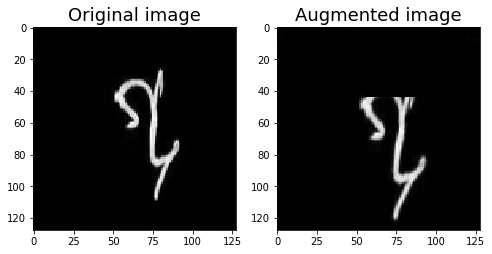

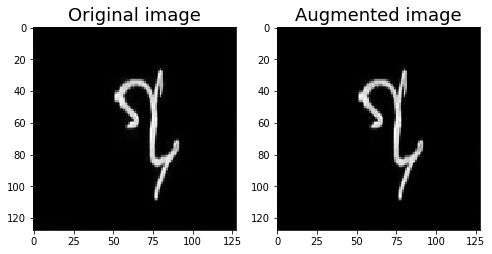

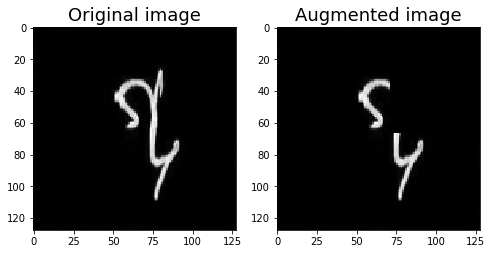

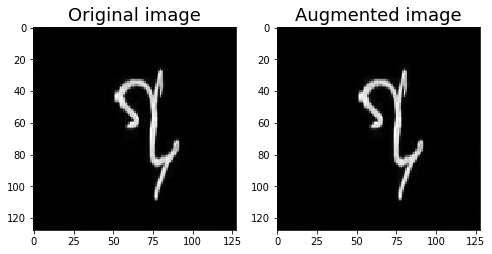

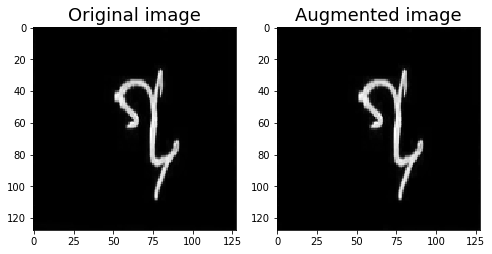

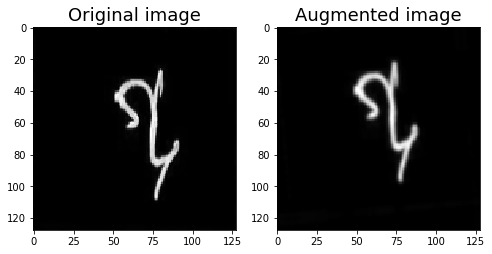

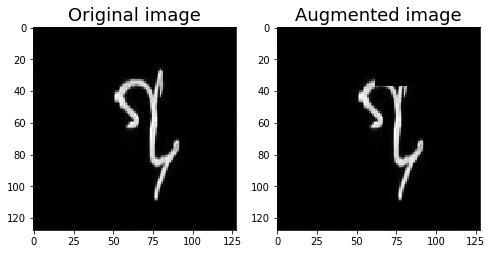

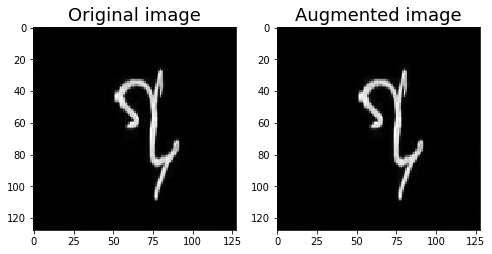

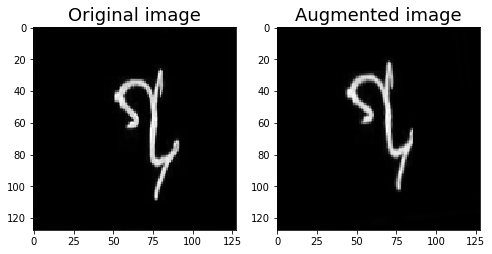

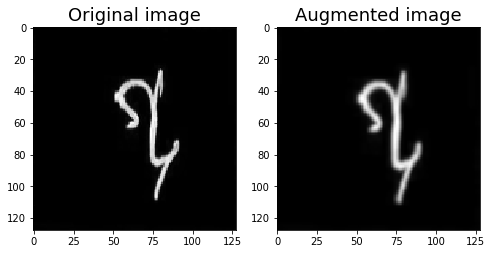

In [0]:
for i in range (10):
    aug_image = train_dataset[0][0]
    visualize (orig_image,aug_image)

In [0]:
del train_df,valid_df,data_train_df,data_valid_df 
torch.cuda.empty_cache()
gc.collect()

46677

In [0]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,num_workers = 16,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=batch_size,num_workers = 16,shuffle=True)

In [0]:
def mixup(x, shuffle, _lambda, i, j):
    if shuffle is not None and _lambda is not None and i == j:
        x = _lambda * x + (1 - _lambda) * x[shuffle]
    return x

In [0]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        #h = torch.cat([x, x, x], dim=1)
        #x = self.base_model.features(h)

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # vowel_diacritic
        self.fc1 = nn.Linear(512 * block.expansion,11)
        # grapheme_root
        self.fc2 = nn.Linear(512 * block.expansion,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(512 * block.expansion,7)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        '''if isinstance(x, tuple):
          x, shuffle, _lambda = x
        else:
         
          shuffle = None
          _lambda = None'''
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        #j = np.random.randint(4)
        #x = mixup(x, shuffle, _lambda, 0, j) 
        x = self.layer1(x)
        #x = mixup(x, shuffle, _lambda, 1, j) 
        x = self.layer2(x)
        #x = mixup(x, shuffle, _lambda, 2, j) 
        x = self.layer3(x)
        #x = mixup(x, shuffle, _lambda, 3, j) 
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        return x1,x2,x3
        #return torch.tensor( (x1,x2,x3), dtype=torch.float64)

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [0]:
class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        #h = torch.cat([x, x, x], dim=1) #hereeeeeeeeee
        #x = self.base_model.features(h)
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [0]:
def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [0]:
'''class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
        super(ResidualBlock,self).__init__()
        self.cnn1 =nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm2d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()
            
    def forward(self,x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        return x


class mixResNet34(nn.Module):
    def __init__(self):
        super(mixResNet34,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=2,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.block2 = nn.Sequential(
            nn.MaxPool2d(1,1),
            ResidualBlock(64,64),
            ResidualBlock(64,64,2)
        )
        
        self.block3 = nn.Sequential(
            ResidualBlock(64,128),
            ResidualBlock(128,128,2)
        )
        
        self.block4 = nn.Sequential(
            ResidualBlock(128,256),
            ResidualBlock(256,256,2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256,512),
            ResidualBlock(512,512,2)
        )
        
        self.avgpool = nn.AvgPool2d(2)
        # vowel_diacritic
        self.fc1 = nn.Linear(512,11)
        # grapheme_root
        self.fc2 = nn.Linear(512,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(512,7)
        


    def forward(self, x):
      if isinstance(x, list):
          x, shuffle, _lambda = x
      else:
          shuffle = None
          _lambda = None
      j = np.random.randint(5)
      
      x = mixup(x, shuffle, _lambda, 0, j)
      x = self.block1(x)
      x = mixup(x, shuffle, _lambda, 1, j)
      x = self.block2(x)
      x = mixup(x, shuffle, _lambda, 2, j)
      x = self.block3(x)
      x = mixup(x, shuffle, _lambda, 3, j)
      x = self.block4(x)
      x = mixup(x, shuffle, _lambda, 4, j)
      x = self.block5(x)
      x = self.avgpool(x)
      x = x.view(x.size(0),-1)
      x1 = self.fc1(x)
      x2 = self.fc2(x)
      x3 = self.fc3(x)
      return x1,x2,x3'''


'class ResidualBlock(nn.Module):\n    def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):\n        super(ResidualBlock,self).__init__()\n        self.cnn1 =nn.Sequential(\n            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),\n            nn.BatchNorm2d(out_channels),\n            nn.ReLU(True)\n        )\n        self.cnn2 = nn.Sequential(\n            nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),\n            nn.BatchNorm2d(out_channels)\n        )\n        if stride != 1 or in_channels != out_channels:\n            self.shortcut = nn.Sequential(\n                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),\n                nn.BatchNorm2d(out_channels)\n            )\n        else:\n            self.shortcut = nn.Sequential()\n            \n    def forward(self,x):\n        residual = x\n        x = self.cnn1(x)\n        x = self.cnn2(x)\n        x += self.sho

In [0]:
"""
Creates a GhostNet Model as defined in:
GhostNet: More Features from Cheap Operations By Kai Han, Yunhe Wang, Qi Tian, Jianyuan Guo, Chunjing Xu, Chang Xu.
https://arxiv.org/abs/1911.11907
Modified from https://github.com/d-li14/mobilenetv3.pytorch
"""
import torch
import torch.nn as nn
import math


__all__ = ['ghost_net']


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, channel // reduction),
                nn.ReLU(inplace=True),
                nn.Linear(channel // reduction, channel),        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        y = torch.clamp(y, 0, 1)
        return x * y


def depthwise_conv(inp, oup, kernel_size=3, stride=1, relu=False):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size, stride, kernel_size//2, groups=inp, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True) if relu else nn.Sequential(),
    )

class GhostModule(nn.Module):
    def __init__(self, inp, oup, kernel_size=1, ratio=2, dw_size=3, stride=1, relu=True):
        super(GhostModule, self).__init__()
        self.oup = oup
        init_channels = math.ceil(oup / ratio)
        new_channels = init_channels*(ratio-1)

        self.primary_conv = nn.Sequential(
            nn.Conv2d(inp, init_channels, kernel_size, stride, kernel_size//2, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential(),
        )

        self.cheap_operation = nn.Sequential(
            nn.Conv2d(init_channels, new_channels, dw_size, 1, dw_size//2, groups=init_channels, bias=False),
            nn.BatchNorm2d(new_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential(),
        )

    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        out = torch.cat([x1,x2], dim=1)
        return out[:,:self.oup,:,:]


class GhostBottleneck(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se):
        super(GhostBottleneck, self).__init__()
        assert stride in [1, 2]

        self.conv = nn.Sequential(
            # pw
            GhostModule(inp, hidden_dim, kernel_size=1, relu=True),
            # dw
            depthwise_conv(hidden_dim, hidden_dim, kernel_size, stride, relu=False) if stride==2 else nn.Sequential(),
            # Squeeze-and-Excite
            SELayer(hidden_dim) if use_se else nn.Sequential(),
            # pw-linear
            GhostModule(hidden_dim, oup, kernel_size=1, relu=False),
        )

        if stride == 1 and inp == oup:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                depthwise_conv(inp, inp, 3, stride, relu=True),
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        return self.conv(x) + self.shortcut(x)


class GhostNet(nn.Module):
    def __init__(self, cfgs, num_classes=1000, width_mult=1.):
        super(GhostNet, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = cfgs

        # building first layer
        output_channel = _make_divisible(16 * width_mult, 4)
        layers = [nn.Sequential(
            nn.Conv2d(1, output_channel, 3, 2, 1, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True)
        )]
        input_channel = output_channel

        # building inverted residual blocks
        block = GhostBottleneck
        for k, exp_size, c, use_se, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 4)
            hidden_channel = _make_divisible(exp_size * width_mult, 4)
            layers.append(block(input_channel, hidden_channel, output_channel, k, s, use_se))
            input_channel = output_channel
        self.features = nn.Sequential(*layers)

        # building last several layers
        output_channel = _make_divisible(exp_size * width_mult, 4)
        self.squeeze = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, 1, 1, 0, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        input_channel = output_channel

        output_channel = 1280
        self.classifier = nn.Sequential(
            nn.Linear(input_channel, output_channel, bias=False),
            nn.BatchNorm1d(output_channel),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(output_channel, num_classes),
        )

        self._initialize_weights()
        # vowel_diacritic
        self.fc1 = nn.Linear(960 ,11)
        # grapheme_root
        self.fc2 = nn.Linear(960 ,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(960 ,7)

    def forward(self, x):
        x = self.features(x)
        x = self.squeeze(x)
        x = x.view(x.size(0), -1)
        #x = self.classifier(x)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        return x1,x2,x3
        #return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


def ghost_net(**kwargs):
    """
    Constructs a MobileNetV3-Large model
    """
    cfgs = [
        # k, t, c, SE, s 
        [3,  16,  16, 0, 1],
        [3,  48,  24, 0, 2],
        [3,  72,  24, 0, 1],
        [5,  72,  40, 1, 2],
        [5, 120,  40, 1, 1],
        [3, 240,  80, 0, 2],
        [3, 200,  80, 0, 1],
        [3, 184,  80, 0, 1],
        [3, 184,  80, 0, 1],
        [3, 480, 112, 1, 1],
        [3, 672, 112, 1, 1],
        [5, 672, 160, 1, 2],
        [5, 960, 160, 0, 1],
        [5, 960, 160, 1, 1],
        [5, 960, 160, 0, 1],
        [5, 960, 160, 1, 1]
    ]
    return GhostNet(cfgs, **kwargs)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#model = se_resnext50().to(device)
#model.load_state_dict(torch.load('/content/drive/My Drive/ors_bengal/cutmixup_seresnext.pth'))
epochs = 50
model = ghost_net().to(device)


cuda:0


In [0]:
from torch.nn.parameter import Parameter
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
model.avg_pooling = GeM()

#model.load_state_dict(torch.load('/content/drive/My Drive/black_128/Deepresnet34cutmix.pth'))
#model.load_state_dict(torch.load('/content/drive/My Drive/ors_bengal/ors_b4.pth'))

model

GhostNet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): GhostBottleneck(
      (conv): Sequential(
        (0): GhostModule(
          (primary_conv): Sequential(
            (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (cheap_operation): Sequential(
            (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
        )
        (1): Sequential()
        (2): Sequential()
        (3): GhostModule(
          (pri

In [0]:
import math
import torch
from torch.optim.optimizer import Optimizer
import numpy as np
import torch.nn as nn
#import torch.optim as Optimizer

# Original source:  https://github.com/shivram1987/diffGrad/blob/master/diffGrad.py

# modifications: @lessw2020


class DiffGrad(Optimizer):
    r"""Implements diffGrad algorithm. It is modified from the pytorch implementation of Adam.
    It has been proposed in `diffGrad: An Optimization Method for Convolutional Neural Networks`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _diffGrad: An Optimization Method for Convolutional Neural Networks:
        https://arxiv.org/abs/1909.11015
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, version=0, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        
        super().__init__(params, defaults)
        
        #save version
        self.version = version

    def __setstate__(self, state):
        super().__setstate__(state)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('diffGrad does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    # Previous gradient
                    state['previous_grad'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq, previous_grad = state['exp_avg'], state['exp_avg_sq'], state['previous_grad']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # compute diffgrad coefficient (dfc)
                
                
                if self.version==0:
                    diff = abs(previous_grad - grad)
                elif self.version ==1:
                    diff = previous_grad-grad
                elif self.version ==2:
                    diff =  .5*abs(previous_grad - grad)
                    
                if self.version==0 or self.version==1:    
                    dfc = 1. / (1. + torch.exp(-diff))
                elif self.version==2:
                    dfc = 9. / (1. + torch.exp(-diff))-4      #DFC2 = 9/(1+e-(.5/g/)-4 #range .5,5
                    
                state['previous_grad'] = grad

                # update momentum with dfc
                exp_avg1 = exp_avg * dfc

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg1, denom)

        return loss

In [0]:
optimizer = DiffGrad(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5, 2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                            mode="min", 
                                                            patience=5, 
                                                            factor=0.3,verbose=True)
criter = nn.CrossEntropyLoss()
batch_size=128

In [0]:
def ohem_loss( rate, cls_pred, cls_target ):

    batch_size = cls_pred.size(0) 
    ohem_cls_loss = F.cross_entropy(cls_pred, cls_target, reduction='none', ignore_index=-1)

    sorted_ohem_loss, idx = torch.sort(ohem_cls_loss, descending=True)
    keep_num = min(sorted_ohem_loss.size()[0], int(batch_size*rate) )
    if keep_num < sorted_ohem_loss.size()[0]:
        keep_idx_cuda = idx[:keep_num]
        ohem_cls_loss = ohem_cls_loss[keep_idx_cuda]
    cls_loss = ohem_cls_loss.sum() / keep_num
    return cls_loss


def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets
# loss 
def cutmix_criterion(preds1,preds2,preds3, targets, rate=0.7):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    #criterion = ohem_loss
    lo1 = lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2)
    lo2 = lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4)
    lo3 = lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)
    return lo1,lo2,lo3


def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def mixup_criterion(preds1,preds2,preds3, targets, rate=0.7):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    #criterion = ohem_loss
    lo1 = lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2)
    lo2 = lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4)
    lo3 = lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)
    return  lo1,lo2,lo3 
    #return [ lam * criterion(rate, preds1, targets1) + (1 - lam) * criterion(rate, preds1, targets2), lam * criterion(rate, preds2, targets3) + (1 - lam) * criterion(rate, preds2, targets4), lam * criterion(rate, preds3, targets5) + (1 - lam) * criterion(rate, preds3, targets6) ]

In [0]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(y[:, 0], pred_labels[0],  average='macro')
    recall_vowel = sklearn.metrics.recall_score(y[:, 1], pred_labels[1],  average='macro')
    recall_consonant = sklearn.metrics.recall_score(y[:, 2], pred_labels[2],  average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score

def macro_recall_multi(pred_graphemes, true_graphemes,pred_vowels,true_vowels,pred_consonants,true_consonants, n_grapheme=168, n_vowel=11, n_consonant=7):
    #pred_y = torch.split(pred_y, [n_grapheme], dim=1)
    pred_label_graphemes = torch.argmax(pred_graphemes, dim=1).cpu().numpy()

    true_label_graphemes = true_graphemes.cpu().numpy()
    
    pred_label_vowels = torch.argmax(pred_vowels, dim=1).cpu().numpy()

    true_label_vowels = true_vowels.cpu().numpy()
    
    pred_label_consonants = torch.argmax(pred_consonants, dim=1).cpu().numpy()

    true_label_consonants = true_consonants.cpu().numpy()    
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(true_label_graphemes, pred_label_graphemes,  average='macro')
    recall_vowel = sklearn.metrics.recall_score(true_label_vowels, pred_label_vowels,  average='macro')
    recall_consonant = sklearn.metrics.recall_score(true_label_consonants, pred_label_consonants,  average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    #print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [0]:
import numpy
def train(epoch,train_loader):
  model.train()
  losses = []
  accs = []
  acc= 0.0
  total = 0.0
  running_loss = 0.0
  running_acc = 0.0
  running_recall = 0.0
  for idx, (inputs,labels1,labels2,labels3) in enumerate(train_loader):
      inputs = inputs.to(device)
      labels1 = labels1.to(device)
      labels2 = labels2.to(device)
      labels3 = labels3.to(device)
      total += len(inputs)
      optimizer.zero_grad()
      outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float())
      loss1 = criter(outputs1,labels1)
      loss2 = 2* criter(outputs2,labels2)
      loss3 = criter(outputs3,labels3)
      running_loss += loss1.item()+loss2.item()+loss3.item()
      running_recall+= macro_recall_multi(outputs2,labels2,outputs1,labels1,outputs3,labels3)
      running_acc += (outputs1.argmax(1)==labels1).float().mean()
      running_acc += (outputs2.argmax(1)==labels2).float().mean()
      running_acc += (outputs3.argmax(1)==labels3).float().mean()
      (loss1+loss2+loss3).backward()
      optimizer.step()
      optimizer.zero_grad()
      acc = running_acc/total
      #scheduler.step(running_loss)
  losses.append(running_loss/len(train_loader))
  accs.append(running_acc/(len(train_loader)*3))
  print(' train epoch : {}\tacc : {:.2f}%'.format(epoch,running_acc/(len(train_loader)*3)))
  print('loss : {:.4f}'.format(running_loss/len(train_loader)))
  print('recall: {:.4f}'.format(running_recall/len(train_loader)))
  total_train_recall = running_recall/len(train_loader)
  torch.cuda.empty_cache()
  gc.collect()
  return  total_train_recall
    
def evaluate(epoch,valid_loader):
   model.eval()
   losses = []
   accs = []
   recalls = []
   acc= 0.0
   total = 0.0
   #print('epochs {}/{} '.format(epoch+1,epochs))
   running_loss = 0.0
   running_acc = 0.0
   running_recall = 0.0
   with torch.no_grad():
     for idx, (inputs,labels1,labels2,labels3) in enumerate(valid_loader):
        inputs = inputs.to(device)
        labels1 = labels1.to(device)
        labels2 = labels2.to(device)
        labels3 = labels3.to(device)
        total += len(inputs)
        outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float())
        loss1 = criter(outputs1,labels1)
        loss2 = 2*criter(outputs2,labels2)
        loss3 = criter(outputs3,labels3)
        running_loss += loss1.item()+loss2.item()+loss3.item()
        running_recall+= macro_recall_multi(outputs2,labels2,outputs1,labels1,outputs3,labels3)
        running_acc += (outputs1.argmax(1)==labels1).float().mean()
        running_acc += (outputs2.argmax(1)==labels2).float().mean()
        running_acc += (outputs3.argmax(1)==labels3).float().mean()
        acc = running_acc/total
   shed_rec = running_loss/len(valid_loader)
   scheduler.step(shed_rec)
   losses.append(running_loss/len(valid_loader))
   accs.append(running_acc/(len(valid_loader)*3))
   recalls.append(running_recall/len(valid_loader))
   total_recall = running_recall/len(valid_loader)
   print('val epoch: {} \tval acc : {:.2f}%'.format(epoch,running_acc/(len(valid_loader)*3)))
   print('loss : {:.4f}'.format(running_loss/len(valid_loader)))
   print('recall: {:.4f}'.format(running_recall/len(valid_loader)))
   return  total_recall

In [0]:
pip install iterative-stratification

In [0]:
os.listdir('/content/drive/My Drive/black_128/')

['train_data_33_l.feather',
 'train_data_00_l.feather',
 'train_data_11_l.feather',
 'train_data_22_l.feather',
 'resnext101_128.pth',
 'se_resnext101.pth',
 'Mixup_se_resnext101.pth',
 'train_data_3_ors.feather',
 'train_data_1_ors.feather',
 'train_data_2_ors.feather',
 'train_data_0_ors.feather',
 'resnet34.pth',
 'bestresnet34.pth',
 'densenet121.pth',
 'bestresnet34Cutmixup.pth',
 'updatedbestresnet34Cutmixup.pth',
 'Deepresnet34cutmix.pth',
 'Myresnet34cutmix.pth',
 'train_v2.csv',
 'ghostnet_fold_0_0.9402.pth',
 'ghostnet_fold_0_0.9405.pth',
 'ghostnet_fold_0_0.9406.pth',
 'ghostnet_fold_0_0.9427.pth',
 'ghostnet_fold_0_0.9510.pth',
 'ghostnet_fold_0_0.9512.pth',
 'ghostnet_fold_0_0.9527.pth',
 'ghostnet_fold_0_0.9530.pth',
 'ghostnet_fold_0_0.9539.pth',
 'ghostnet_fold_0_0.9547.pth',
 'ghostnet_fold_0_0.9550.pth',
 'ghostnet_fold_0_0.9568.pth',
 'ghostnet_fold_0_0.9570.pth',
 'ghostnet_fold_0_0.9572.pth',
 'ghostnet_fold_0_0.9573.pth',
 'ghostnet_fold_0_0.9576.pth',
 'ghostnet_

In [0]:
train_df = pd.read_csv('/content/drive/My Drive/black_128/train_v2.csv')

In [0]:
import gc
#train_df = train
n_epochs = 200
nfold = 5
seed = 321
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import StratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=nfold, random_state=seed)

#skf = StratifiedKFold(nfold, random_state= seed)
#mskf = skf
model.load_state_dict(torch.load('/content/drive/My Drive/black_128/ghostnet_fold_0_0.9583.pth'))
for i, (train_index, test_index) in enumerate(mskf.split(X, y)):
  
  optimizer = DiffGrad(model.parameters(), lr=0.001)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                            mode="min", 
                                                            patience=5, 
                                                            factor=0.3,verbose=True)
  if (i != 0):  
    print(f'----------------------------current fold is : {i+1}   --------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------------------------')
    traindf = train_df.iloc[train_index]
    validdf = train_df.iloc[test_index]
    data_traindf = data_full.iloc[train_index]
    data_validdf = data_full.iloc[test_index]
    train_dataset = GraphemeDataset(data_traindf ,traindf,transform = True) 
    valid_dataset = GraphemeDataset(data_validdf ,validdf,transform = False) 
    torch.cuda.empty_cache()
    gc.collect() 
    del traindf,validdf,data_traindf,data_validdf
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,num_workers = 16, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=batch_size,num_workers = 16,shuffle=True)
    valid_recall = 0.0
    best_valid_recall = 0.9572
    for epoch in range(n_epochs):
      torch.cuda.empty_cache()
      gc.collect()
      train_recall = train(epoch,train_loader)
      valid_recall = evaluate(epoch,valid_loader)
      if valid_recall > best_valid_recall:
          print(f'Validation recall has increased from:  {best_valid_recall:.4f} to: {valid_recall:.4f}. Saving checkpoint')
          torch.save(model.state_dict(), f'/content/drive/My Drive/black_128/ghostnet_fold_{i}_{valid_recall:.4f}.pth') ## Saving model weights based on best validation recall.
          best_valid_recall = valid_recall
      

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


----------------------------current fold is : 2   --------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 train epoch : 0	acc : 0.94%
loss : 0.9918
recall: 0.8863
val epoch: 0 	val acc : 0.99%
loss : 0.1119
recall: 0.9853
Validation recall has increased from:  0.9572 to: 0.9853. Saving checkpoint
 train epoch : 1	acc : 0.93%
loss : 0.9944
recall: 0.8845
val epoch: 1 	val acc : 0.99%
loss : 0.1397
recall: 0.9814
 train epoch : 2	acc : 0.93%
loss : 0.9972
recall: 0.8848
val epoch: 2 	val acc : 0.99%
loss : 0.1643
recall: 0.9789
 train epoch : 3	acc : 0.93%
loss : 0.9809
recall: 0.8862
val epoch: 3 	val acc : 0.99%
loss : 0.1594
recall: 0.9794
 train epoch : 4	acc : 0.94%
loss : 0.9791
recall: 0.8868
val epoch: 4 	val acc : 0.99%
loss : 0.1620
recall: 0.9790
 train epoch : 5	acc : 0.94%
loss : 0.9609
recall: 0.8883
val epoch: 5 	val acc : 0.99%
loss : 0.1773
recall: 0.9758
 train epoch : 6	acc : 0.94%
loss : 0.9541
recall: 0.8882
Epoch     7: reducing learning rate of group 0 to 3.0000e-04.
val epoch: 6 	val acc : 0.99%
loss : 0.1891
recall: 0.9747
 train epoch : 7	acc : 0.94%
loss : 0.8411


In [0]:
# this is gonna rock!! :) :).